###**06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷**
**규제 선형 모델의 개요**
- 회귀 모델은 적절히 데이터에 적합하면서도 회귀계수가 기하급수적으로 커지는 것을 제어할 수 있어야 함
- 지금까지 선형 모델 비용 함수는 RSS를 최소화하여 실제값과 예측값의 차이를 최소화 하는 것만 고려함 -> 학습데이터에 지나치게 맞추게 되고, 회귀 계수가 쉽게 커지는 문제 발생 (예측 성능 저하)

  => 학습데이터의 잔차 오류 값을 최소호 하는 RSS 최소화 방법 + 과적합을
  방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법의 균형 필요

- 비용 함수 목표 = Min(RSS(W)) + alpha*||W||^2_2
   - alpha: 학습데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터
    - alpha = 0인 경우는 W가 커도 alpha*||W||^2_2가 0이 되어 비용 함수는 Min(RSS(W))가 됨
    - alpha = 무한대인 경우 alpha*||W||^2_2도 무한대가 되어 비용함수는 W를 0에 가깝게 최소화 해야 함

    => 비용함수에 alpha 값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 '규제(Regularization)'를 진행

**규제**
- 크게 L1방식과 L2방식으로 구분됨
- L2규제: W의 제곱에 대해 패널티를 부여하는 방식으로, 릿지(Ridge)회귀라고 부름
- L1규제: W의 절댓값에 대해 패널티를 부여하는 방식으로, 라쏘(Lasso)회귀라고 부름
  - L1규제는 영향력이 크지 않은 회귀 계수 값을 0으로 변환함

**릿지 회귀**
- 주요 생성 파라미터: alpha
- alpha는 릿지회귀의 alpha L2 규제 계수라고도 불리움


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# boston 데이터 세트 로드(원본데이터 직접 불러오)
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
    'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
]

# boston 데이터세트 DataFrame 변환
bostonDF = pd.DataFrame(data, columns=columns)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼으로 DataFrame에 추가함.
bostonDF['PRICE'] = target
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True,  copy_X=True, n_jobs=1)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE: {1:.3f}'. format(mse, rmse))
print('Variance score: {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE: 4.159
Variance score: 0.757


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행.
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores: ', np.round(rmse_scores, 3))
print('5 folds의 개별 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 개별 RMSE: 5.518


LinearRegression에 비해 더 뛰어난 예측 성능을 보여주는 것을 알 수 있다.
이제 alpha 값을 변화하면서 RMSE 값과 각 피처의 회귀 계수를 시각화하고 DataFrame에 저장해보자

In [ ]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas:
  ridge = Ridge(alpha = alpha)

  # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
  neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = 'neg_mean_squared_error', cv=5)
  avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
  print('alpha {0}일 때 5 folds의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE: 5.829
alpha 0.1일 때 5 folds의 평균 RMSE: 5.788
alpha 1일 때 5 folds의 평균 RMSE: 5.653
alpha 10일 때 5 folds의 평균 RMSE: 5.518
alpha 100일 때 5 folds의 평균 RMSE: 5.330


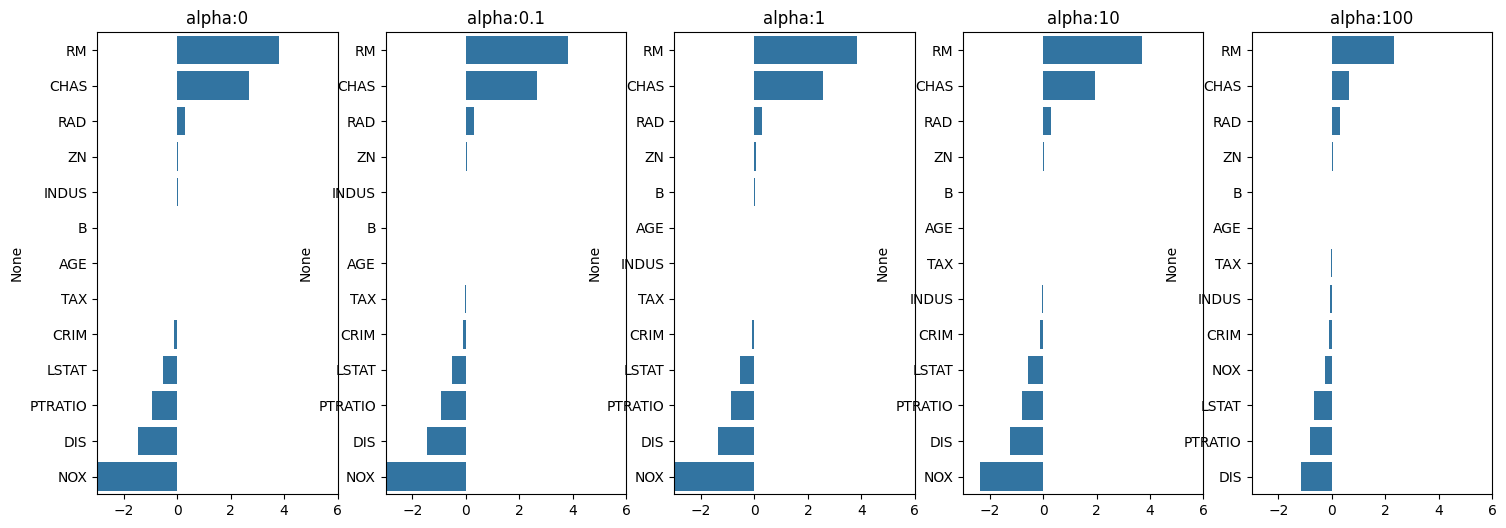

In [ ]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위하 DataFrame을 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력하여 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_data, y_target)
  # alpha에 따른 피처 별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
  coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
  colname='alpha:'+str(alpha)
  coeff_df[colname] = coeff
  # 막대 그래프로 각 alpha값에서의 회귀 계수를 시각화. 회귀 계수 값이 높은 순으로 표현
  coeff = coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3, 6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

# for문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

해당 그래프를 확인하면, alpha값을 계속 증가시킬수록 회귀 계수 값은 지속적으로 작아짐을 알 수 있다. 특히 NOX 피처의 경우 alpha값을 증가시킴에 따라 회귀 계수가 크게 작아지는 것을 확인 가능하다.

In [ ]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending= False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


표로 확인해도 alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있음을 알 수 있다. 하지만 릿지 회귀의 경우 회귀 계수를 0으로 만들지는 않는 것을 알 수 있다.

**라쏘 회귀**
- W의 절댓값에 패널티를 부여하는 L1규제를 선형 회귀에 적용한 것
- L2 규제가 회귀 계수의 크기를 감소시키는데 반해, L1규제의 경우 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가짐

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMS를 출력하고, 회귀 계수값들은 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,
                        verbose=True, return_coeff=True):
  coeff_df = pd.DataFrame()
  if verbose: print('#######', model_name, '#######')
  for param in params:
    if model_name == 'Ridge': model = Ridge(alpha=param)
    elif model_name == 'Lasso': model = Lasso(alpha=param)
    elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1* neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

    model.fit(X_data_n, y_target_n)
    if return_coeff:
      # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
      coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
      colname = 'alpha:'+str(param)
      coeff_df[colname] = coeff

  return coeff_df
# end of get_linear_regre_eval

In [ ]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval()함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

####### Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


alpha가 0.07일따 가장 좋은 RMSE를 보여주는 것을 확인할 수 있다. 이에 대한 피처별 회귀계수를 확인하자.

In [ ]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:' + str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


릿지회귀와는 달리 라쏘의 경우 alpha의 크기가 증가함에 따라 일부 피처의 회귀계수는 아예 0으로 바뀌는 것을 확인할 수 있다. 이때 회귀 계수가 0인 피처는 회귀식에서 제외되면서 피처 선택의 효과를 얻을 수 있다.

**엘라스틱넷 회귀**
- L1과 L2를 결합한 회귀
- 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우에는 이들 중 중요 피처만을 셀렉하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강하기 때문에 이를 완화하기 위해 L2규제를 추가한 회귀를 의미
- 단점: :L1과 L2가 결합함에 따라 수행시간이 상대적으로 오래 걸림
- 주요 생성 파라미터: alpha, l1_ratio

먼저 alpha값의 변화를 살펴보기 위해 l1_ratio의 값을 고정하고 객체를 생성해보자.

In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값을 정의하고, get_linear_reg_eval()함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07,0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n = X_data, y_target_n=y_target)

####### ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [ ]:
# 반횐된 coeff_elastic_df를 첫 번째 칼럼 순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:' + str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


아까와는 달리 alpha 0.5일때 RMSE가 가장 좋은 예측 성능을 보이고 있고, alpha값에 따른 피처들의 회귀 계수값이 라쏘보단 상대적으로 0이 되는 값이 적음을 알 수 있음

이와 같이 규제 선형 회귀의 대표적 3가지 기법인 릿지, 라쏘, 엘라스틱을 보았는데, 이들은 상황에 따라 좋은 기법이 달라지기 때문에 각 알고리즘에서 하이퍼 파라미터를 변경해가며 최적의 예측 성능을 찾아내야 함.

하지만, 이와 못지않게 데이터 분포도의 정규화와 인코딩 방법이 중요함

**선형 회귀 모델을 위한 데이터 변환**
- 선형 모델은 일반적으로 피처와 타깃값 간에 선형의 관계가 있다고 가정하고 이러한 최적의 선형함수를 찾아내어 결과값을 예측함
- 선형 회귀 모델의 경우 피처값과 타깃값의 분포가 '정규분포의 형태'를 매우 선호함
- 사이킷런을 이용한 피처 데이터 세트의 변환 작업은 다음과 같음
1. StandardScaler 클래스를 이용하여 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터 세트로 변환하거나 MinMaxScaler클래스를 이용하여 최솟값이 0, 최댓값이 1인 값으로 정규화를 수행
2. 스케일링/ 정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환하는 방법으로, 보통 1번 방법을 통해 예측 성능에 향상이 없는 경우에 적용
3. 원래 값에 log 함수를 적용하면 보다 정규분포에 가까운 형태로 값이 분포되는데, 이러한 변환을 로그변환(Log Transformation)이라고 함. (실제 가장 많이 사용하는 변환 방법)


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최솟값의 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2 이상 부여하지 않음.
def get_scaled_data(method='None', p_degree=None, input_data=None):
  if method == 'Standard':
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax':
    scaled_data = MinMaxScaler().fit_transform(input_data)
  else:
    scaled_data = input_data

  if p_degree != None:
    scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

  return scaled_data

이제 Ridge 클래스의 alpha값을 변화시키면서 피처 데이터 세트를 여러가지 방법으로 변환한 데이터 세트를 입력받을 경우 RMSE의 값이 어떻게 변하는지를 살펴보자.

** 피처 데이터의 변환 방법**
- (None, None): 아무런 변환을 하지 않은 원본 데이터
- ('Standard', None): 표준 정규 분포
- ('Standard', 2): 표준 정규 분포를 다시 2차 다항식 변환 진행
- ('MinMax', None): 최솟값/최댓값 정규화
- ('MinMax', 2): 최솟값/최댓값 정규화를 다시 2차 다항식 변환 진행
- ('Log', None): 로그 변환

In [ ]:
# Ridge의 alpha값을 다르게 적용하고 다앙햔 데이터 변환 방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]

# 5개의 방식으로 변환. 먼저 원본 그대로, 표준정규분포, 표준 정규분포 + 다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그 변환
scale_methods = [(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
  X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
  print('\n## 변환유형: {0}, Polynomial Degree: {1}'. format(scale_method[0], scale_method[1]))
  get_linear_reg_eval ('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False, return_coeff=False)


## 변환유형: None, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환유형: Standard, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환유형: Standard, Polynomial Degree: 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634

## 변환유형: MinMax, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635

## 변환유형: MinMax, Polynomial Degree: 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538

## 변환유형: Log, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE:

** 버전의 차이로 log 변환 유형의 RMSE값이 상이하게 나타남
alpha 0.1 : MinMax, 2차 다항식 변환 RMSE  5.298로 개선
alpha 1: MinMax, 2차 다항식 변환 RMSE 4.323으로 개선
alpha 10: MinMax, 2차 다항식 변환 RMSE 5.185로 개선
alpha 100: Standard, 2차 다항식 변환 RMSE 4.634로 개선

즉 해당 값에서는 로그 변환보다 최솟값 최댓값 정규화로 일차 변환 후 2차 다항식 변환을 진행하였을 때 전체적으로 성능이 개선된 것을 확인할 수 있음.

### **07. 로지스틱 회귀**
**로지스틱 회귀**
- 선형 회귀 방식을 분류에 적용한 알고리즘
- 학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아닌 시그모이드(Sigmoid) 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주하여 확률에 따라 분류를 결정함
- 사이킷런은 로지스틱 회귀를 위해 LogisticRegression 클래스를 제공

**시그모이드 함수**
- S자 커브형태를 가지는 함수
- x값이 +, -로 아무리 커지나 작어져도 y값은 항상 0과 1 사이 값을 반환함

(x값이 커지면 1에 근사하며 x값이 작아지면 0에 근사함, x가 0일때는 0,5를 가짐)

**LogisticRegression 클래스**
- solver 파라미터를 다양하게 적용하면서 최적화 선택 가능
  - lbfgs: 사이킷런 버전 0.22부터 solver의 기본 설정값으로 CPU 코어 수가 많은 경우 최적화를 병렬로 수행가능
  - liblinear: 다차원이고 작은 데이터 세트에서 더 효과적으로 동작하나 국소 최적화(Local Minimum)가 존재할 수 있고 병렬로 최적화할 수 없음
  - newton_cg: 좀 더 정교한 최적화가 가능하나 대용량의 데이터에서 속도가 많이 느려짐
  - sag: Stochastic Average Gradient로 경사 하강법 기반의 최적화를 적용함, 대용량의 데이터에서 빠르게 최적화 가능
  - saga: sag와 유사한 최적화 방식이고, L1 정규화를 가능하게 함
- 엄청난 차이가 존재하는 것이 아닌 미비한 차이를 낳기 때문에 위의 2개를 가장 많이 사용

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산이 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행.
# solver 인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

# accuray와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc: {1:.3f}'.format(accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

accuracy: 0.977, roc_auc: 0.995


** 책에는 fit 코드가 없어 오류 발생, lr_clf을 먼저 fit 한 후 진행

이젠 다양한 solver 값을 가지고 최적화 알고리즘을 진행하자. 이때 최대 반복횟수는 600으로, 이를 max_iter을 통해 지정해서 진행하자.

In [ ]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

# 여러 개의 solver 값별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
  lr_clf = LogisticRegression(solver=solver, max_iter=600)
  lr_clf.fit(X_train, y_train)
  lr_preds = lr_clf.predict(X_test)
  lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

  # accuracy와 roc_auc 측정
  print('solver:{0}, accuracy: {1:.3f}, roc_auc:{2:.3f}'.format(solver, accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

solver:lbfgs, accuracy: 0.977, roc_auc:0.995
solver:liblinear, accuracy: 0.982, roc_auc:0.995
solver:newton-cg, accuracy: 0.977, roc_auc:0.995
solver:sag, accuracy: 0.982, roc_auc:0.995
solver:saga, accuracy: 0.982, roc_auc:0.995


위의 코드에서 이용한 max_iter 이외에도 사이킷런 LogisticRegression 클래스의 주요 하이퍼 파라미터에는 penalty와 C가 있음
- penaly: 규제의 유형을 설정 (l2: L2규제, l1: L1 규제)
- C: 규제의 강도를 조절하는 alpha값의 역수로, C값이 작을수록 규제 강도가 커짐

  - Liblinear, saga는 L1, L2가 모두 가능하나, lbfgs, newton-cg는 L2 규제만 가능함

In [ ]:
from sklearn.model_selection import GridSearchCV

params ={'solver':['liblinear', 'lbfgs'],
         'penalty': ['l2', 'l1'],
         'C': [0.01, 0.1, 1, 5, 10]}
lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터: {0}, 최적 평균 정확도: {1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도: 0.979


로지스틱 회귀는 가볍고 빠르나 이진 분류 예측 성능도 뛰어나기 때문에 이를 기본 모델로 사용하는 경우가 많다. 또한 로지스틱 회귀의 경우 희소한 데이터 세트 분류에도 뛰어난 성능을 보이기 때문에 텍스트 분류에도 자주 사용된다.

###**08. 회귀 트리**
**회귀 트리**
- 트리기반 회귀는 회귀 트리를 이용하는 것을 의미함
- 분류 트리가 특정 클래스 레이블을 결정하는 것과 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구하여 회귀 예측값을 계산함
- 트리 생성은 CART(Classification And Regression Trees)를 기반으로 하기 때문에 결정트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 의 모든 트리기반 알고리즘이 가능함 (사이킷런의 Estimator에선 약간의 차이가 존재할 수 있음)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 보스턴 데이터 세트 로드
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
    'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
]
# boston 데이터세트 DataFrame 변환
bostonDF = pd.DataFrame(data, columns=columns)

bostonDF['PRICE'] = target

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 교차 검증의 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores:  [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE: 4.423


In [ ]:
def get_model_cv_prediction(model, X_data, y_target):
  neg_mse_scores=cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
  rmse_scores = np.sqrt(-1*neg_mse_scores)
  avg_rmse = np.mean(rmse_scores)
  print('#####', model.__class__.__name__, '#####')
  print('5 교차 검증의 평균 RMSE: {0:.3f}'.format(avg_rmse))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state = 0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
  get_model_cv_prediction(model, X_data, y_target)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

features_importances_를 이용하여 피처별 중요도를 알아보자.

<Axes: xlabel='None', ylabel='None'>

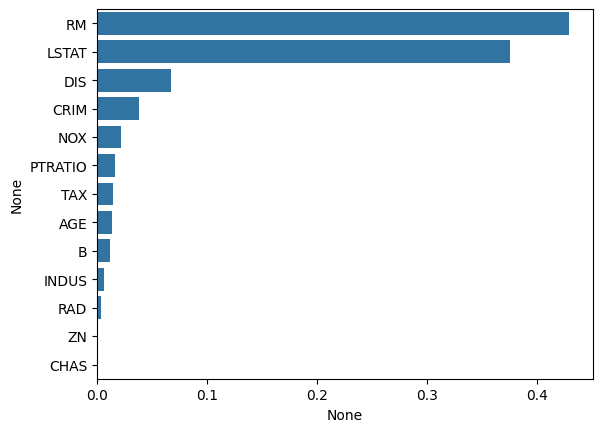

In [ ]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습을 수행하자.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

이번에는 회귀 트리 Regressor 가 어떻게 예측값을 판단하는지 선형 회귀와 비교하여 시각화해보도록 하자
이때 보스텐 데이터 세트의 개수를 100개만 샘플링하고 중요도가 가장 높았던 RM과 PRICE 칼럼만 추출하자

(100, 2)


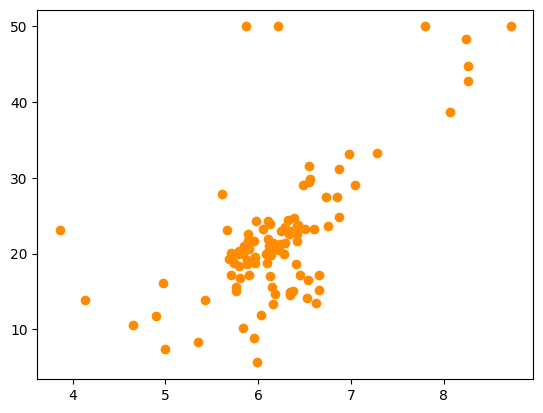

In [ ]:
bostonDF_sample = bostonDF[['RM', 'PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')

다음은 보스턴 데이터 세트에 대해 LinearRegression과 DecisionTreeRegressor을 max_depth를 각 2, 7로 하여 학습하도록 하자

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

#선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개 데이터 세트로 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1, 1)

# 학습과 예측 수행.
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

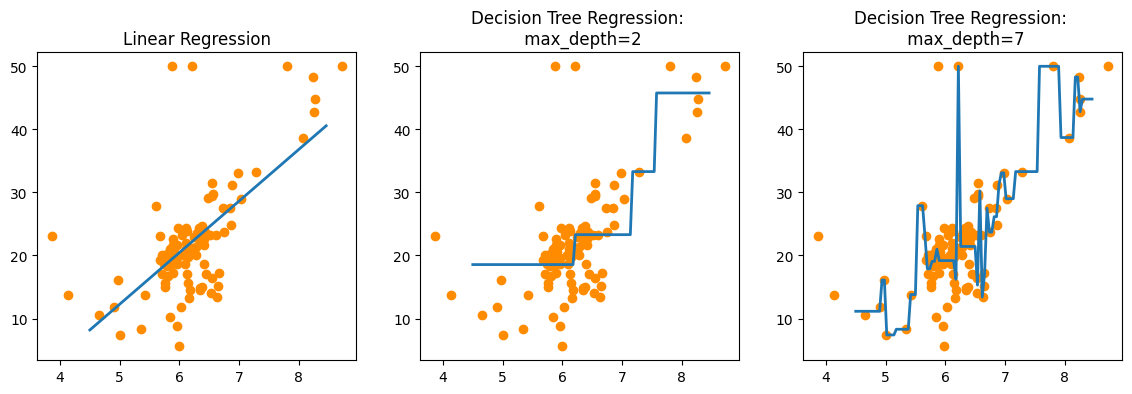

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 4), ncols=3)

# X축 값을 4.5~ 8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth:2', linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3. plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)

선형회귀는 직선으로 회귀선을 예측하는데 반해 회귀 트리는 계단 형태로 회귀선을 형성함을 알 수 있다. 또한 max_depth=7인 데이터를 보면 학습 데이터의 이상치까지 학습이 되어 모델이 과적합 되었음을 확인할 수 있다.